# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). The analysis will be the same, and some numbers are going to change, with the larger dataset.

In [4]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix


import re
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

! pip install user_agents
from user_agents import parse

import re

%matplotlib inline

In [5]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify')\
    .getOrCreate()

In [6]:
# all the parameter of spark Context
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '34793'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1623744299903'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '8c1dce5d7d12')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. We will load and clean the dataset using Spark, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
# load data
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)

In [8]:
# print first five rows
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
df.select('userId').dropDuplicates().sort('userId').show() # an empty space is found here

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [11]:
def clean_data(df):
    '''
    Drop invalid or missing data
    '''
    df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
    df = df.filter(df['userId'] != '')
    return df

In [12]:
df = clean_data(df)

In [13]:
# checking for null values in columns
df_null = df.agg(*[count(when(isnull(c), c)).alias(c) for c in df.columns])
df_null.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [14]:
df.filter(df.song.isNotNull()).select('page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



The columns: artist, length, and song are empty when the page is not 'NextSong'. These are not invalid data.

# Exploratory Data Analysis


### Define Churn

We will create a column `Churn` to use as the label for our model. We will use the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users.


In [15]:
def create_label(df):
    '''
    Create a column 'Churn' to use as the label for the model. 
    '''
    
    churned_users = df.where(df.page == 'Cancellation Confirmation').select('userId').distinct()
    churned_users_list = list(churned_users.select('userId').toPandas()['userId'])
    df = df.withColumn('Churn', df.userId.isin(churned_users_list))
    
    return df

In [16]:
df = create_label(df)

In [17]:
df.groupby(df.Churn).agg(countDistinct('userId')).show()

+-----+----------------------+
|Churn|count(DISTINCT userId)|
+-----+----------------------+
| true|                    52|
|false|                   173|
+-----+----------------------+



In [18]:
print('{0:.0%} of users have churned'.format(52/(52+173)))

23% of users have churned






### Explore Data
Here we are going to perform exploratory data analysis to observe the behavior for users who stayed vs users who churned.

In [19]:
# print the first five rows
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False


### User Analysis

#### Gender and Churn

In [20]:
gender = df.groupby(df.Churn, df.gender).agg(countDistinct('userId')).toPandas()

In [21]:
gender.sort_values(by='gender')

,Churn,gender,count(DISTINCT userId)
0,True,F,20
3,False,F,84
1,False,M,89
2,True,M,32


In [22]:
print('{0:.0%} of female users have churned'.format(20/(20+84)))

19% of female users have churned


In [23]:
print('{0:.0%} of male users have churned'.format(32/(32+89)))

26% of male users have churned


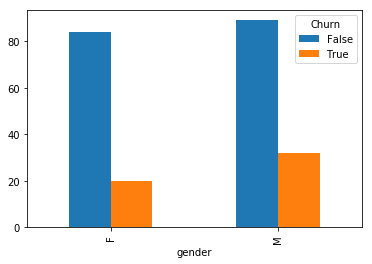

In [24]:
gender.pivot(index='gender', columns='Churn', values = 'count(DISTINCT userId)').plot(kind='bar');

#### Level and Churn

In [25]:
level = df.groupby(df.Churn, df.level).agg(countDistinct('userId')).toPandas()

In [26]:
level.sort_values(by='level')

,Churn,level,count(DISTINCT userId)
0,False,free,149
3,True,free,46
1,False,paid,129
2,True,paid,36


In [27]:
print('{0:.0%} of free level users have churned'.format(46/(46+149)))

24% of free level users have churned


In [28]:
print('{0:.0%} of paid level users have churned'.format(36/(36+129)))

22% of paid level users have churned


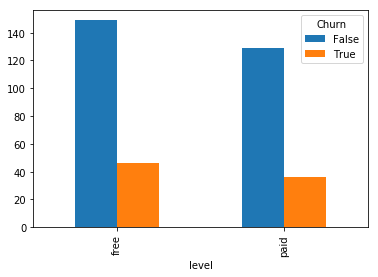

In [29]:
level.pivot(index='level', columns='Churn', values = 'count(DISTINCT userId)').plot(kind='bar');

Male users have higher proportion of churn, and Free users have higher proportion of churn than free users.

## Activities

Activitiy-related variables aggregated on churn.

In [30]:
df.groupby(df.Churn, df.auth).agg(countDistinct('sessionId')).show()

+-----+---------+-------------------------+
|Churn|     auth|count(DISTINCT sessionId)|
+-----+---------+-------------------------+
| true|Cancelled|                       52|
|false|Logged In|                     2110|
| true|Logged In|                      468|
+-----+---------+-------------------------+



In [31]:
df.groupby(df.Churn).agg(avg('itemInSession')).show()

+-----+------------------+
|Churn|avg(itemInSession)|
+-----+------------------+
| true|109.23299304564907|
|false| 115.9888465000643|
+-----+------------------+



In [32]:
df.groupby(df.Churn).agg(avg('length')).show()

+-----+------------------+
|Churn|       avg(length)|
+-----+------------------+
| true|248.63279564406366|
|false|249.20913538881427|
+-----+------------------+



In [33]:
df.groupby(df.Churn, df.method).agg(countDistinct('sessionId')).show()

+-----+------+-------------------------+
|Churn|method|count(DISTINCT sessionId)|
+-----+------+-------------------------+
|false|   PUT|                     2059|
| true|   PUT|                      457|
|false|   GET|                     2009|
| true|   GET|                      450|
+-----+------+-------------------------+



In [34]:
page = df.groupby(df.page, df.Churn).agg(countDistinct('sessionId')).sort('page', 'Churn').toPandas()

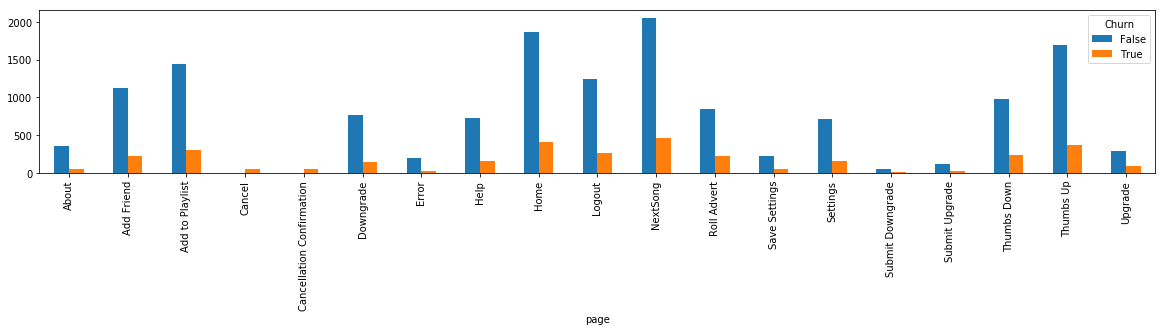

In [35]:
page.pivot(index='page', columns='Churn', values = 'count(DISTINCT sessionId)').plot(kind='bar', figsize=(20,3));

In [36]:
pagedf = page.groupby(['page', 'Churn'])['count(DISTINCT sessionId)'].sum()
page_pcts = pagedf.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [37]:
page_pcts

page                       Churn
About                      False     87.990196
                           True      12.009804
Add Friend                 False     83.037037
                           True      16.962963
Add to Playlist            False     82.746682
                           True      17.253318
Cancel                     True     100.000000
Cancellation Confirmation  True     100.000000
Downgrade                  False     83.552632
                           True      16.447368
Error                      False     86.666667
                           True      13.333333
Help                       False     81.777278
                           True      18.222722
Home                       False     82.029877
                           True      17.970123
Logout                     False     82.419035
                           True      17.580965
NextSong                   False     81.832669
                           True      18.167331
Roll Advert                

Difficult to have a clear interaction between visited page and churn.
Atributes like Roll Avert, Submit Downgrade/Upgrade, Thumbs down, Upgrade seems to have stronger relationship with Churn than other page visits.

# Feature Engineering

In [38]:
# Functions for feature engineering

def int_label(df):
    df = df.withColumn('label', df['Churn'].cast(IntegerType()))
    return df

def tenure(df):
    '''
    Calculate tenure: the last interacted date - registration date
    '''
    max_ts_df = df.groupBy('userId').agg(max('ts').alias('max_ts'))
    df = df.join(max_ts_df, on=['userId'], how = 'left')
    df = df.withColumn('tenure', ((df.max_ts-df.registration)/86400000).cast(IntegerType()))    
    
    return df

def state_variable(df):
    '''
    Create State from location
    '''
    get_state = udf(lambda x: x.split(',')[1])
    df = df.withColumn('state', get_state(df.location))

    return df

def device_variables(df):
    
    get_browser = udf(lambda x: parse(x).browser.family)
    get_os = udf(lambda x: parse(x).os.family)
    get_device = udf(lambda x: parse(x).device.family)
    df = df.withColumn('browser', get_browser(df.userAgent))
    df = df.withColumn('os', get_os(df.userAgent))
    df = df.withColumn('device', get_device(df.userAgent))
    
    return df

def user_stats(df):
    '''
    Create user level stats
    '''
    w = Window.partitionBy(df.userId)
    df = df.withColumn('num_songs', approx_count_distinct(df.song).over(w))
    df = df.withColumn('num_artists', approx_count_distinct(df.artist).over(w))
    df = df.withColumn('avg_length', avg(df.length).over(w))
    
    return df    

def page_variables(df):
    '''
    Based on EDA, create variables indicating if a user visited specific pages
    In addition to the pages that show stronger relationship with churn, 
    we will make variables for Add Friend and Add to Playlist page visits
    '''
    
    RollAdvert = df.where(df.page == 'Roll Advert').select('userId').distinct()
    RollAdvert_list = list(RollAdvert.select('userId').toPandas()['userId'])
    df = df.withColumn('roll_advert', df.userId.isin(RollAdvert_list))
    
    Downgrade = df.where(df.page == 'Submit Downgrade').select('userId').distinct()
    Downgrade_list = list(Downgrade.select('userId').toPandas()['userId'])
    df = df.withColumn('downgrade', df.userId.isin(Downgrade_list))
    
    Upgrade = df.where(df.page == 'Submit Upgrade').select('userId').distinct()
    Upgrade_list = list(Upgrade.select('userId').toPandas()['userId'])
    df = df.withColumn('upgrade', df.userId.isin(Upgrade_list))
   
    Thumbsdown = df.where(df.page == 'Thumbs Down').select('userId').distinct()
    Thumbsdown_list = list(Thumbsdown.select('userId').toPandas()['userId'])
    df = df.withColumn('thumbsdown', df.userId.isin(Thumbsdown_list))
    
    AddFriend = df.where(df.page == 'Add Friend').select('userId').distinct()
    AddFriend_list = list(AddFriend.select('userId').toPandas()['userId'])
    df = df.withColumn('addfriend', df.userId.isin(AddFriend_list))
    
    AddtoPlaylist = df.where(df.page == 'Add to Playlist').select('userId').distinct()
    AddtoPlaylist_list = list(AddtoPlaylist.select('userId').toPandas()['userId'])
    df = df.withColumn('addtoplaylist', df.userId.isin(AddtoPlaylist_list))
    
    return df

In [39]:
df = int_label(df)
df = tenure(df)
df = state_variable(df)
df = device_variables(df)
df = user_stats(df)
df = page_variables(df)

In [40]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,device,num_songs,num_artists,avg_length,roll_advert,downgrade,upgrade,thumbsdown,addfriend,addtoplaylist
0,100010,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,274,249,243.421445,True,False,False,True,True,True
1,100010,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,274,249,243.421445,True,False,False,True,True,True
2,100010,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,274,249,243.421445,True,False,False,True,True,True
3,100010,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,274,249,243.421445,True,False,False,True,True,True
4,100010,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,274,249,243.421445,True,False,False,True,True,True


In [41]:
def drop_columns(df):
    '''
    Drop unnecessary columns before modeling
    '''
    columns_to_drop = ['userId', 'artist', 'auth', 'firstName', 'itemInSession', 'lastName', 'length', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status',
                       'ts', 'userAgent', 'max_ts', 'Churn']
    
    df = df.drop(*columns_to_drop) 
    
    return df

In [42]:
df_model = drop_columns(df)

In [43]:
pd.DataFrame(df_model.orderBy(rand()).take(5), columns=df_model.columns)

,gender,level,label,tenure,state,browser,os,device,num_songs,num_artists,avg_length,roll_advert,downgrade,upgrade,thumbsdown,addfriend,addtoplaylist
0,M,paid,0,71,AZ,Firefox,Mac OS X,Mac,1497,1191,250.803833,True,False,True,True,True,True
1,M,paid,0,51,MS,Chrome,Mac OS X,Mac,605,599,247.944090,True,False,False,True,True,True
2,F,free,0,108,MN-WI,Chrome,Windows,Other,1019,932,245.194959,True,False,True,True,True,True
3,M,paid,1,19,KY,Chrome,Windows,Other,1897,1392,247.880551,False,False,False,True,True,True
4,M,paid,0,60,MA-NH,Chrome,Windows,Other,2298,1600,248.345298,True,True,True,True,True,True


# Modeling
Here we are going to split the full dataset into train, test, and validation sets. Then test out machine learning methods like logistic regresion, random forest classifier and gradient.boosted tree classifier. We are going to evaluate the accuracy of the various models, tuning parameters as necessary, and then we will  determine the winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, we will use F1 score as the metric to optimize.

In [44]:
train, test = df_model.randomSplit([0.7, 0.3], seed=42)

In [45]:
# get the dimensions of the data
print(train.count(), len(train.columns))
print(test.count(), len(test.columns))

194876 17
83278 17


In [46]:
# String Indexer for OneHotEncoderEstimator
SI_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
SI_level = StringIndexer(inputCol='level', outputCol='level_index')
SI_state = StringIndexer(inputCol='state', outputCol='state_index')
SI_browser = StringIndexer(inputCol='browser', outputCol='browser_index')
SI_os =  StringIndexer(inputCol='os', outputCol='os_index')
SI_device= StringIndexer(inputCol='device', outputCol='device_index')

# OneHotEncoderEstimator
OHE = OneHotEncoderEstimator(inputCols=['gender_index', 'level_index', 'state_index', 'browser_index', 'os_index', 'device_index'],
                             outputCols=['gender_OHE', 'level_OHE', 'state_OHE', 'browser_OHE', 'os_OHE', 'device_OHE'])

# Create a vector of all numeric features for scaling
num_assembler = VectorAssembler(inputCols=['tenure', 'num_songs', 'num_artists', 'avg_length'], outputCol='NumFeatures')

# Standard scaler for numeric features
scaler = StandardScaler(inputCol='NumFeatures', outputCol='ScaledNumFeatures', withStd=True)

# Create a vector of all features for modeling
feature_assembler = VectorAssembler(inputCols=['ScaledNumFeatures', 'gender_OHE', 'level_OHE', 'state_OHE', 'browser_OHE', 'os_OHE', 'device_OHE', 
                                              'roll_advert', 'downgrade', 'upgrade', 'thumbsdown', 'addfriend', 'addtoplaylist'], 
                                    outputCol='features')

# Logistic regresion model
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_pipeline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, lr])

# Random Forest Classifier model
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_pipeline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, rf])

# Gradient.Boosted tree classifier model
gbt = GBTClassifier(featuresCol='features', labelCol='label')
gbt_pipeline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, gbt])

In [47]:
# training models 
lr_model = lr_pipeline.fit(train)
rf_model = rf_pipeline.fit(train)
gbt_model = gbt_pipeline.fit(train)

In [48]:
# obtain predictions
lr_preds = lr_model.transform(test)
rf_preds = rf_model.transform(test)
gbt_preds = gbt_model.transform(test)

####  Evaluation (F1 and Accuracy)

In [49]:
my_eval = MulticlassClassificationEvaluator(labelCol = 'label')

In [50]:
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

In [51]:
# Calculating metrics
acc = acc_eval.evaluate(lr_preds)
f1 = f1_eval.evaluate(lr_preds)
print(f'Accuracy: {acc:<4.2%} F-1 Score: {f1:<4.3f}')

Accuracy: 90.88% F-1 Score: 0.904


In [52]:
# Calculating metrics
acc = acc_eval.evaluate(rf_preds)
f1 = f1_eval.evaluate(rf_preds)
print(f'Accuracy: {acc:<4.2%} F-1 Score: {f1:<4.3f}')

Accuracy: 90.50% F-1 Score: 0.888


In [53]:
# Calculating metrics
acc = acc_eval.evaluate(gbt_preds)
f1 = f1_eval.evaluate(gbt_preds)
print(f'Accuracy: {acc:<4.2%} F-1 Score: {f1:<4.3f}')

Accuracy: 99.07% F-1 Score: 0.991


In [54]:
# Confusion matrix for gbt
y_true = gbt_preds.select(['label']).collect()
y_pred = gbt_preds.select(['prediction']).collect()

In [55]:
print(classification_report(np.hstack(y_true),np.hstack(y_pred)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     69783
          1       1.00      0.94      0.97     13495

avg / total       0.99      0.99      0.99     83278



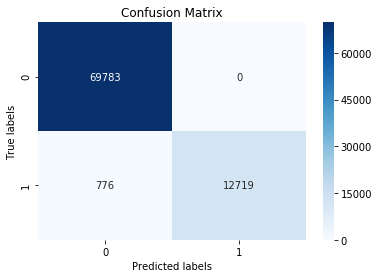

In [56]:
ax = plt.subplot()
conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, ax = ax, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

#### Step 5. Code for Hyper Parameter Tunin

In [57]:
# Set the Parameters grid
gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [3, 5])  
                 .addGrid(gbt.maxBins, [15, 30]) 
                 .build())

gbt_cv = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=gbt_paramGrid, 
                        evaluator=my_eval, numFolds = 3, seed=42, parallelism=2)

In [58]:
cvModel = gbt_cv.fit(train)

In [59]:
cvResults = cvModel.transform(test)

In [60]:
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

In [61]:
# Calculating metrics
acc = acc_eval.evaluate(cvResults)
f1 = f1_eval.evaluate(cvResults)
print(f'Accuracy: {acc:<4.2%} F-1 Score: {f1:<4.3f}')

Accuracy: 99.34% F-1 Score: 0.993
